In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from utils import show_graph

In [28]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [40]:
def train():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    iterep = 500
    for i in range(iterep * 30):
        x_train, y_train = mnist.train.next_batch(100)
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': mnist.train.images,
                                     'y:0': mnist.train.labels,
                                     'phase:0': 1})
            t = sess.run([loss, accuracy], 
                         feed_dict={'x:0': mnist.test.images,
                                    'y:0': mnist.test.labels,
                                    'phase:0': 0})
            history += [[epoch] + tr + t]
            print history[-1]
    return history

# No batch normalization

In [25]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [26]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_relu(x, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, y))

In [27]:
show_graph(tf.get_default_graph().as_graph_def())

In [41]:
history = train()

[1, 0.62786102, 0.84640002, 0.60159862, 0.852]
[2, 0.42104557, 0.88401818, 0.3991476, 0.89060003]
[3, 0.36023715, 0.89643639, 0.34092355, 0.90420002]
[4, 0.32714283, 0.90738183, 0.31200293, 0.91350001]
[5, 0.30525991, 0.91136366, 0.29238802, 0.9181]
[6, 0.28594673, 0.91845453, 0.27396005, 0.92129999]
[7, 0.27217323, 0.92278183, 0.26227644, 0.92570001]
[8, 0.25747102, 0.92621815, 0.24811827, 0.92820001]
[9, 0.24657567, 0.92963636, 0.23810224, 0.93110001]
[10, 0.23555622, 0.93283635, 0.22762109, 0.93370003]
[11, 0.22645245, 0.93554544, 0.22099651, 0.93699998]
[12, 0.21775192, 0.93754548, 0.21259634, 0.93730003]
[13, 0.2106484, 0.93978184, 0.20524472, 0.94120002]
[14, 0.20395662, 0.94134545, 0.20126368, 0.94279999]
[15, 0.19531132, 0.94394547, 0.1919032, 0.9454]
[16, 0.18853153, 0.94641817, 0.18666312, 0.94690001]
[17, 0.18247418, 0.94814545, 0.18202794, 0.94620001]
[18, 0.1773262, 0.94929093, 0.17549393, 0.94870001]
[19, 0.17174274, 0.95160002, 0.17235704, 0.94859999]
[20, 0.16599169, 0.

# Standard batch normalization

In [42]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, scope='dense')
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [43]:
tf.reset_default_graph()
x = tf.placeholder('float32', (None, 784), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

h1 = dense_batch_relu(x, phase,'layer1')
h2 = dense_batch_relu(h1, phase, 'layer2')
logits = tf.contrib.layers.fully_connected(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, y))

In [44]:
show_graph(tf.get_default_graph().as_graph_def())

In [45]:
history_bn = train()

[1, 0.43518507, 0.89634544, 1.491143, 0.81489998]
[2, 0.28868839, 0.92805457, 1.1570184, 0.89850003]
[3, 0.22705756, 0.94160002, 0.82386535, 0.92640001]
[4, 0.19043651, 0.95083636, 0.54877079, 0.94]
[5, 0.16420846, 0.95798182, 0.36231649, 0.94889998]
[6, 0.14496356, 0.96229088, 0.25523806, 0.95310003]
[7, 0.12985225, 0.96705455, 0.20134909, 0.95569998]
[8, 0.11747493, 0.96943635, 0.16848506, 0.95950001]
[9, 0.10764621, 0.97236365, 0.15239441, 0.95920002]
[10, 0.098850459, 0.97527272, 0.14054616, 0.9637]
[11, 0.091095313, 0.97741818, 0.13301089, 0.96499997]
[12, 0.083874665, 0.97923636, 0.12456006, 0.96649998]
[13, 0.078095138, 0.98043638, 0.12231704, 0.9666]
[14, 0.072299913, 0.98238182, 0.11890828, 0.96509999]
[15, 0.067735061, 0.98360002, 0.11424309, 0.96710002]
[16, 0.063209802, 0.98470908, 0.11282893, 0.9677]
[17, 0.059508111, 0.98603636, 0.10991687, 0.96880001]
[18, 0.055624574, 0.98707271, 0.10790427, 0.96869999]
[19, 0.052293707, 0.98827273, 0.10819675, 0.96869999]
[20, 0.048897

# Evaluation

In [46]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [47]:
history = np.array(history)
history_bn = np.array(history_bn)

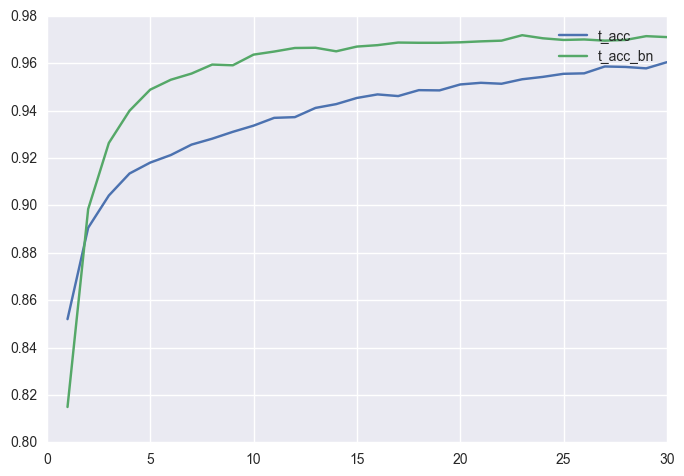

In [55]:
plt.plot(history[:, 0], history[:, -1], label='t_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='t_acc_bn')
plt.legend()